In [1]:
import glob
from pathlib import Path
import itertools
import nibabel as nib
import numpy as np
import pandas as pd

def search(base_dir, wildcard, error=True):
    search_path = Path(base_dir) / wildcard
    files = glob.glob(str(search_path))

    if not files:
        if error:
            raise FileNotFoundError(f"No files were found in: {search_path}")
        else:
            return []

    return files

def filter_run_ids(run_ids):
    KEEP = ['01', '02', '03', 'IMTest', 'IMRetest']
    KEEP = [f"run-{i}" for i in KEEP]
    filtered_run_ids = []
    for run_id in run_ids:
        if run_id.split('/')[-1] in KEEP or "X" in run_id:
            filtered_run_ids.append(run_id)

    return filtered_run_ids

In [2]:
scratch_dir = Path("/scratch/fastfmri")
IM_MODULATION_EXPERIMENT_IDS = ["020", "021"]
SUPPORTED_IDS = [
    "1_frequency_tagging_3T_entrain",
    #"1_frequency_tagging_7T_entrain",
    "1_attention_7T_AttendAway",
]
DSCALAR_TEMPLATE = "/opt/app/notebooks/data/dscalars/S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"


experiment_id = "1_frequency_tagging"
mri_id = "3T"
task_base = "entrain"
session_ids = ["run-01", "run-02", "run-03"]

assert f"{experiment_id}_{mri_id}_{task_base}" in SUPPORTED_IDS



sub_fla_dirs = search(scratch_dir, f"experiment-{experiment_id}_mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/sub-*")
sub_fla_dirs.sort()
sub_ids = []
task_suffices = []
for i in sub_fla_dirs:
    _dir = Path(i)
    sub_id = _dir.stem
    if sub_id in [f"sub-{_id}" for _id in IM_MODULATION_EXPERIMENT_IDS]:
        continue
    sub_ids.append(sub_id)
    
    search_str = str(_dir).split("/")[3]
    truncate_id = search_str.split('truncate-')[1].split('_')[0]
    smooth_id = search_str.split('smooth-')[1].split('_')[0]

    tasks = search(scratch_dir, f"experiment-{experiment_id}*mri-{mri_id}*smooth-0*batch-00_desc-IMsubtraction_bootstrap/first_level_analysis/{sub_id}/*/task-{task_base}*")
    assert len(tasks) == 1
    task_suffix = tasks[0][-2:]
    task_suffices.append(task_suffix)

In [3]:
import sys
sys.path.append("./ComputeCanada/frequency_tagging")
from im_recall_precision import *

f_1, f_2, f_im = 0.125, 0.2, 0.075

n_datasets = 0
for ix, ((sub_id, task_suffix), ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
    task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
        [ses_id],
        mri_id, 
        smooth_id,
        truncate_id,
        scratch_dir,
        sub_id,
        task_suffix,
        f_1, f_2, f_im,
        metric_types=["stat"],
        task_base=task_base,
        experiment_id=experiment_id,
        dscalar_template=DSCALAR_TEMPLATE,
    )
    # Get mask of all cortical vertices
    if ix == 0:
        wb_coverage_mask = (task_f1_data['stat'][ses_id]>0).astype(int)
    else:
        wb_coverage_mask += (task_f1_data['stat'][ses_id]>0).astype(int)

    n_datasets += 1

wb_coverage_mask = wb_coverage_mask / n_datasets 
wb_coverage_mask = (wb_coverage_mask == 1.).astype(int)
print(wb_coverage_mask.sum())
    

16255


In [4]:
def dice_coefficient(mask_a, mask_b):
    intersection = (mask_a & mask_b).sum()
    size_a = mask_a.sum()
    size_b = mask_b.sum()
    
    dice = (2 * intersection) / (size_a + size_b)
    
    return dice

from sklearn.metrics import recall_score

dc_to_self = []
dc_to_other = []
dc_R = np.zeros((len(sub_ids) * len(session_ids), len(sub_ids) * len(session_ids)))

recall_to_self = []
recall_to_other = []
recall_R = np.zeros((len(sub_ids) * len(session_ids), len(sub_ids) * len(session_ids)))
for r_ix, ((r_sub_id, r_task_suffix), r_ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
    
    task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
        [r_ses_id],
        mri_id, 
        smooth_id,
        truncate_id,
        scratch_dir,
        r_sub_id,
        r_task_suffix,
        f_1, f_2, f_im,
        metric_types=["z_score", "p_value", "stat"],
        task_base=task_base,
        experiment_id=experiment_id,
        dscalar_template=DSCALAR_TEMPLATE,
    )
    # Get P-value corrected map
    task_f1_mask = process_mask(task_f1_data, correction_type="fdr")[r_ses_id].astype(int)
    task_f2_mask = process_mask(task_f2_data, correction_type="fdr")[r_ses_id].astype(int)
    f1_f2_intersection = (task_f1_mask + task_f2_mask) == 2
    f1_f2_intersection = (f1_f2_intersection[wb_coverage_mask==1]).astype(int)

    for c_ix, ((c_sub_id, c_task_suffix), c_ses_id) in enumerate(itertools.product(zip(sub_ids, task_suffices), session_ids)):
        task_f1_data, task_f2_data, task_im_data = load_multitype_maps(
            [c_ses_id],
            mri_id, 
            smooth_id,
            truncate_id,
            scratch_dir,
            c_sub_id,
            c_task_suffix,
            f_1, f_2, f_im,
            metric_types=["z_score", "p_value", "stat"],
            task_base=task_base,
            experiment_id=experiment_id,
            dscalar_template=DSCALAR_TEMPLATE,
        )
        # Get P-value corrected map
        task_im_mask = process_mask(task_im_data, correction_type="fdr")[c_ses_id].astype(int)
        task_im_mask = (task_im_mask[wb_coverage_mask==1]).astype(int)

        dc = dice_coefficient(f1_f2_intersection, task_im_mask)
        r = recall_score(f1_f2_intersection, task_im_mask)
        if r_sub_id == c_sub_id:
            dc_to_self.append(dc)
            recall_to_self.append(r)
        else:
            dc_to_other.append(dc)
            recall_to_other.append(r)
        dc_R[r_ix, c_ix] = dc
        recall_R[r_ix, c_ix] = r
        print(f"{r_sub_id} [{r_ses_id}] {c_sub_id} [{c_ses_id}] {c_task_suffix}x{r_task_suffix} | {dc:.4f} | {r:.4f}")

sub-000 [run-01] sub-000 [run-01] Q1xQ1 | 0.0866 | 0.4366
sub-000 [run-01] sub-000 [run-02] Q1xQ1 | 0.1366 | 0.4648
sub-000 [run-01] sub-000 [run-03] Q1xQ1 | 0.2065 | 0.2254
sub-000 [run-01] sub-002 [run-01] Q1xQ1 | 0.0319 | 0.2394
sub-000 [run-01] sub-002 [run-02] Q1xQ1 | 0.0857 | 0.0845
sub-000 [run-01] sub-002 [run-03] Q1xQ1 | 0.0000 | 0.0000
sub-000 [run-01] sub-003 [run-01] Q1xQ1 | 0.1004 | 0.3239
sub-000 [run-01] sub-003 [run-02] Q1xQ1 | 0.1002 | 0.3521
sub-000 [run-01] sub-003 [run-03] Q1xQ1 | 0.0468 | 0.2113
sub-000 [run-01] sub-004 [run-01] Q1xQ1 | 0.0599 | 0.1831
sub-000 [run-01] sub-004 [run-02] Q1xQ1 | 0.2437 | 0.4085
sub-000 [run-01] sub-004 [run-03] Q1xQ1 | 0.1097 | 0.1831
sub-000 [run-01] sub-005 [run-01] Q2xQ1 | 0.0203 | 0.1268
sub-000 [run-01] sub-005 [run-02] Q2xQ1 | 0.0063 | 0.0141
sub-000 [run-01] sub-005 [run-03] Q2xQ1 | 0.0000 | 0.0000
sub-000 [run-01] sub-006 [run-01] Q2xQ1 | 0.0000 | 0.0000
sub-000 [run-01] sub-006 [run-02] Q2xQ1 | 0.0060 | 0.0563
sub-000 [run-0

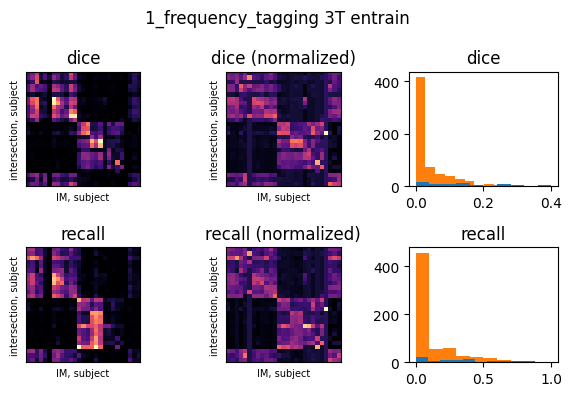

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(6,4))

im = ax[0,0].imshow(dc_R, cmap='magma')
im = ax[0,1].imshow( (dc_R-dc_R.mean(0)) / dc_R.std(0), cmap='magma')
ax[0,2].hist(dc_to_self, alpha=1., bins=10, zorder=2)
ax[0,2].hist(dc_to_other, alpha=1., bins=10, zorder=1)
ax[0,0].set_title("dice")
ax[0,1].set_title("dice (normalized)")
ax[0,2].set_title("dice")

im = ax[1,0].imshow(recall_R, cmap='magma')
im = ax[1,1].imshow( (recall_R-recall_R.mean(0)) / recall_R.std(0), cmap='magma')
ax[1,2].hist(recall_to_self, alpha=1., bins=10, zorder=2)
ax[1,2].hist(recall_to_other, alpha=1., bins=10, zorder=1)
ax[1,0].set_title("recall")
ax[1,1].set_title("recall (normalized)")
ax[1,2].set_title("recall")

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlabel("IM, subject", fontsize=7)
        ax[i, j].set_ylabel("intersection, subject", fontsize=7)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

fig.suptitle(f"{experiment_id} {mri_id} {task_base}")

fig.tight_layout()